In [50]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import ensemble
from scipy.ndimage.measurements import label
import pickle

# HOG

In [113]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []
    for img in imgs:
        img = img[:x, :y]
        img_features = []
    #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = img[:,:,::-1]
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            print('spatial shape', spatial_features.shape)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            print('hist shape', hist_features.shape)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            print('feature image shape', feature_image.shape)
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                print('hog shape', len(hog_features))
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    return features

# Train a classifier

In [210]:
# Load data
vehicle_path = os.path.expanduser("~/Downloads/tl_classifier_exceptsmall/simulator/")
nonvehicle_path = os.path.expanduser("~/Downloads/tl_classifier_exceptsmall/simulator/")
train_vehicles = []
train_nonvehicles = []
test_vehicles = []
test_nonvehicles = []
counter = 0
x = y = 300
for vehicle_file in glob.glob(vehicle_path+'Red/*.png'):
    img = cv2.imread(vehicle_file)
    train_vehicles.append(img)
    if img.shape[0] < x: x = img.shape[0]
    if img.shape[1] < y: y = img.shape[1]
    
nonvehicle_folders = ['Green', 'Yellow', 'NoTrafficLight']
for folder in nonvehicle_folders:
    for nonvehicle_file in glob.glob(nonvehicle_path+folder+'/*.png'):
        img = cv2.imread(nonvehicle_file)
        train_nonvehicles.append(img)
        if img.shape[0] < x: x = img.shape[0]
        if img.shape[1] < y: y = img.shape[1]

In [11]:
print(len(train_vehicles))
len(train_nonvehicles)

337


106

In [215]:
y = 43

In [219]:
# Balance
# train_vehicles = train_vehicles[:len(test_vehicles)]
# test_nonvehicles = test_nonvehicles[:len(test_vehicles)]
# extract features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 720] # Min and max in y to search in slide_window()
train_car_features = extract_features(train_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
train_notcar_features = extract_features(train_nonvehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X_train = np.vstack((train_car_features, train_notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
train_scaled_X = X_scaler.transform(X_train)
# create labels
y = np.hstack((np.ones(len(train_car_features)), 
              np.zeros(len(train_notcar_features))))
# shuffle
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(train_scaled_X, y, test_size=0.2, random_state=rand_state)

spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 4

/Users/christy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image

hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image

hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image

hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image shape (109, 43, 3)
hog shape 420
spatial shape (768,)
hist shape (48,)
feature image

In [220]:
y = 43

In [221]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

0.23 Seconds to train SVC...
Test Accuracy of SVC =  1.0


In [51]:
xOut = open('X_scaler.pkl','wb')
pickle.dump(X_scaler, xOut)
xOut.close()

In [52]:
# save the classifier
svcOut = open('svc.pkl', 'wb')
pickle.dump(svc, svcOut)
svcOut.close()

# Sliding Window Search

In [217]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255 # only for jpeg
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            #print('image block', ytop, ytop+x, xleft, xleft+y)
            if ytop+x < 600 or xleft+y < 800:
                pass
            # Extract HOG for this patch
            #hog_feat1 = get_hog_features(ch1[ytop:ytop+x, xleft:xleft+y], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel() 
            #hog_feat2 = get_hog_features(ch2[ytop:ytop+x, xleft:xleft+y], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            #hog_feat3 = get_hog_features(ch3[ytop:ytop+x, xleft:xleft+y], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #print('hog features img size', nblocks_per_window, nblocks_per_window)
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+x, xleft:xleft+y], (x,y))
            #print('sub image shape', subimg.shape)
            # HOG features
            hog_feat1 = get_hog_features(subimg[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel() 
            hog_feat2 = get_hog_features(subimg[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            hog_feat3 = get_hog_features(subimg[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=True).ravel()
            #print('hog features img size', nblocks_per_window, nblocks_per_window)
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            try:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            except:
                print('ERROR')
                plt.imshow(subimg)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                print('RED LIGHT!')
                return boxes
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    print('NOT RED LIGHT!')
    return boxes

In [203]:
# heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bboxes, img

get image
NOT RED LIGHT!


/Users/christy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


'\nspatial shape (3072,)\nhist shape (96,)\nhog shape 4032\n'

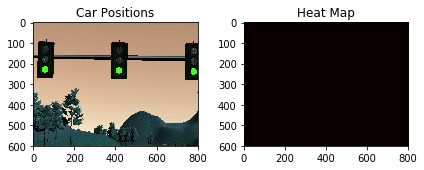

In [225]:
orient = 7  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

ystart = [0]
ystop = [600]
scale = [2]

print('get image')
img = cv2.imread('test/test_186.png')
box_list = []
for i in range(len(ystart)):
    result = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.extend(result)
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
box, draw_img = draw_labeled_bboxes(np.copy(img), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('heatmap.jpg')
'''
spatial shape (3072,)
hist shape (96,)
hog shape 4032
'''

In [ ]:
y